In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import FenicsATL as FATL
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

from multiprocessing import Process


Loading BokehJS ...

In [3]:
mpl.rcParams["figure.facecolor"] = 'white'

In [4]:
FENICS_to_analyse = [15,14,13,12,10,9,8,7,6,5,4] #11 removed
filter_id = [15,14,13,12,10,9,8,7,6,5,4]
filter_id_slow = [15,14,13,12,10,9,8,6,5,4] #7 removed bad integrator

FENICS = FATL.FenicsData_read('/AtlasDisk/home2/sisaid/data/FENICS_data.json')



# FENICS = FATL.FilterbyUniqueChannels(FENICS)

FENICS = FENICS[FENICS.Board.specialTests ==  'None']

Fast = FATL.FenicsTestTable(FENICS,'fast')
Slow = FATL.FenicsTestTable(FENICS,'slow')

FastFeaturesToDrop = [("NoiseHG","Mean"),("NoiseHG","Mu"),
                      ("NoiseHGIG1","Mean"),("NoiseHGIG1","Mu"),
                      ("NoiseHGIG2","Mean"),("NoiseHGIG2","Mu"),
                      ("NoiseHGIG6","Mean"),("NoiseHGIG6","Mu"),
                      ("NoiseLG","Mean"),("NoiseLG","Mu"),
                      ("NoiseLGIG1","Mean"),("NoiseLGIG1","Mu"),
                      ("NoiseLGIG2","Mean"),("NoiseLGIG2","Mu"),
                      ("NoiseLGIG6","Mean"),("NoiseLGIG6","Mu")]

for feature in FastFeaturesToDrop:
    Fast = Fast.drop(feature, axis=1) 

slow_index = Slow.index
Slow.dropna(subset=[('Gain3','Linearity','SlopeLin'),('Gain4','Linearity','SlopeLin'),('Gain5','Linearity','SlopeLin')], inplace=True)
Slow.dropna(inplace=True,axis=1)
Fast.drop(index=slow_index.difference(Slow.index), inplace=True)
FENICS.drop(index=slow_index.difference(Slow.index), inplace=True)


Slow = FATL.Normalizer(Slow)
Fast = FATL.Normalizer(Fast)

FastSlow = pd.concat([Slow, Fast], axis=1)


In [5]:
Slow_filtred = pd.DataFrame()
Slow_filtred = Slow
removed_features_lienarity = ['DACforPed']
Slow_filtred = Slow_filtred.drop([('Gain0',   'NoisePhys'),('Gain1',  'NoisePhys'),
                                    ('Gain2',   'NoisePhys'),('Gain3',   'NoisePhys'),
                                    ('Gain4',   'NoisePhys'),('Gain5',  'NoisePhys')], axis=1) 

Slow12_filtred = Slow_filtred.drop([('Gain0',   'NoisePosPed'),('Gain1',    'NoisePosPed'),
                                    ('Gain2',   'NoisePosPed'),('Gain3',   'NoisePosPed'),
                                    ('Gain4',   'NoisePosPed'),('Gain5',  'NoisePosPed')], axis=1) 

for feature in removed_features_lienarity :
    Slow_filtred = Slow_filtred.drop([('Gain0',   'Linearity',   feature),('Gain1',   'Linearity',    feature),
                                        ('Gain2',   'Linearity',    feature),('Gain3',   'Linearity',    feature),
                                        ('Gain4',   'Linearity',    feature),('Gain5',   'Linearity',    feature)], axis=1)

In [6]:
FENICS2 = FATL.FenicsData_read('/AtlasDisk/home2/sisaid/data/FENICS2_data.json')

# FENICS2 = FENICS2[FENICS2.Board.burnTime.notna()]

# temp_allindex = []
# for id in FENICS2.Board.id.unique() :
#     temp_index = FENICS2[FENICS2.Board.id == id][FENICS2.Board.channel == FENICS2[FENICS2.Board.id == id].Board.channel.value_counts().index[0]].index.tolist()
#     temp_allindex = temp_allindex + temp_index
    
# FENICS2 = FENICS2.loc[temp_allindex]
FENICS2 = FENICS2[(FENICS2.Board.StatusFast != -1) | (FENICS2.Board.StatusSlow != -1)]

Fast2 = FATL.FenicsTestTable(FENICS2,'fast')
Slow2 = FATL.FenicsTestTable(FENICS2,'slow')




for feature in FastFeaturesToDrop:
    Fast2 = Fast2.drop(feature, axis=1) 

slow2_index = Slow2.index

Slow2.dropna(subset=[('Gain0','Linearity','SlopeLin'),('Gain1','Linearity','SlopeLin'),('Gain3','Linearity','SlopeLin'),('Gain4','Linearity','SlopeLin'),('Gain5','Linearity','SlopeLin'),
                     ('Gain0','Linearity','ConstLin'),('Gain1','Linearity','ConstLin'),('Gain3','Linearity','ConstLin'),('Gain4','Linearity','ConstLin'),('Gain5','Linearity','ConstLin'),], inplace=True)
Slow2.dropna(inplace=True,axis=1)
Fast2.drop(index=slow2_index.difference(Slow2.index), inplace=True)
FENICS2.drop(index=slow2_index.difference(Slow2.index), inplace=True)

Slow2 = FATL.Normalizer(Slow2)
Fast2 = FATL.Normalizer(Fast2)


FastSlow2 = pd.concat([Slow2, Fast2], axis=1)

In [7]:
Slow2_filtred = pd.DataFrame()
Slow2_filtred = Slow2
removed_features_lienarity = ['DACforPed']
Slow2_filtred = Slow2_filtred.drop([('Gain0',   'NoisePhys'),('Gain1',  'NoisePhys'),
                                    ('Gain2',   'NoisePhys'),('Gain3',   'NoisePhys'),
                                    ('Gain4',   'NoisePhys'),('Gain5',  'NoisePhys')], axis=1) 

Slow2_filtred = Slow2_filtred.drop([('Gain0',   'NoisePosPed'),('Gain1',    'NoisePosPed'),
                                    ('Gain2',   'NoisePosPed'),('Gain3',   'NoisePosPed'),
                                    ('Gain4',   'NoisePosPed'),('Gain5',  'NoisePosPed')], axis=1) 

for feature in removed_features_lienarity :
    Slow2_filtred = Slow2_filtred.drop([('Gain0',   'Linearity',   feature),('Gain1',   'Linearity',    feature),
                                        ('Gain2',   'Linearity',    feature),('Gain3',   'Linearity',    feature),
                                        ('Gain4',   'Linearity',    feature),('Gain5',   'Linearity',    feature)], axis=1)

In [8]:
FENICS12 = FENICS.append(FENICS2,ignore_index=True)
Fast12 = Fast.append(Fast2,ignore_index=True)
Slow12 = Slow.append(Slow2,ignore_index=True)
Slow12.dropna(subset=[('Gain3','Linearity','SlopeLin'),('Gain4','Linearity','SlopeLin'),('Gain5','Linearity','SlopeLin')], inplace=True)
Slow12.dropna(inplace=True,axis=1)

FastSlow12 = pd.concat([Slow12, Fast12], axis=1)

In [9]:
Slow12_filtred = pd.DataFrame()
Slow12_filtred = Slow12
removed_features_lienarity = ['DACforPed']
Slow12_filtred = Slow12_filtred.drop([('Gain0',   'NoisePhys'),('Gain1',  'NoisePhys'),
                                    ('Gain2',   'NoisePhys'),('Gain3',   'NoisePhys'),
                                    ('Gain4',   'NoisePhys'),('Gain5',  'NoisePhys')], axis=1) 

Slow12_filtred = Slow12_filtred.drop([('Gain0',   'NoisePosPed'),('Gain1',    'NoisePosPed'),
                                    ('Gain2',   'NoisePosPed'),('Gain3',   'NoisePosPed'),
                                    ('Gain4',   'NoisePosPed'),('Gain5',  'NoisePosPed')], axis=1) 

for feature in removed_features_lienarity :
    Slow12_filtred = Slow12_filtred.drop([('Gain0',   'Linearity',   feature),('Gain1',   'Linearity',    feature),
                                        ('Gain2',   'Linearity',    feature),('Gain3',   'Linearity',    feature),
                                        ('Gain4',   'Linearity',    feature),('Gain5',   'Linearity',    feature)], axis=1)

In [10]:
FEN1_ids = [1,4,5,6,7,8,9,10,11,12,13,14,15]
FEN2_batch01_ids = [29,30,31,32,33,34,35,36,37,38,39,40]
FEN2_batch02_ids = [1041,1042,1043,1044,1045,1046,1047]
NIEL_ids = [101,102,103,104,105,111,112,114,115,121,122,123,124,125,131,132,133,134,135]
TID_ids = [106,107,108,109,110,116,117,118,119,120,126,127,128,129,130,136,137,138,139,140,1021,1022,1023,1024,1025]

FENICS12_fail = FENICS12.Board.id[(FENICS12.Board.StatusFast==0 ) | (FENICS12.Board.StatusSlow==0)]
FENICS2_fail = FENICS2.Board.id[(FENICS2.Board.StatusFast==0 ) | (FENICS2.Board.StatusSlow==0)]
FENICS_fail = FENICS.Board.id[(FENICS.Board.StatusFast==0 ) | (FENICS.Board.StatusSlow==0)]

AllFen12 = list(set(FENICS12.Board.id[(FENICS12.Board.StatusFast==0 ) | (FENICS12.Board.StatusSlow==0)])
                .union(set(FEN1_ids),
                       set(FEN2_batch01_ids),
                       set(FEN2_batch02_ids),
                       set(NIEL_ids),
                       set(TID_ids))
                )

AllFen2 = list(set(FENICS2.Board.id[(FENICS2.Board.StatusFast==0 ) | (FENICS2.Board.StatusSlow==0)])
               .union(
                set(FEN2_batch01_ids),
                set(FEN2_batch02_ids),
                set(NIEL_ids),
                set(TID_ids))
                )

AllFen = list(set(FENICS_fail).union(set(FEN1_ids)))

AllFen12LTT = list(set(FEN1_ids).union(set(FEN2_batch01_ids),set(FEN2_batch02_ids)))
AllFen2LTT = list(set(FEN2_batch01_ids).union(set(FEN2_batch02_ids)))



In [11]:
FENICS12_LTT = pd.DataFrame()
for id in AllFen12LTT :
    FENICS12_LTT = pd.concat([FENICS12_LTT,FENICS12.Board[FENICS12.Board.id == id]])
    
FENICS2_LTT = pd.DataFrame()
for id in AllFen2LTT :
    FENICS2_LTT = pd.concat([FENICS2_LTT,FENICS2.Board[FENICS2.Board.id == id]])

In [12]:
main_dir = '/users/divers/atlas/sisaid/home2/'

In [13]:
custom_filter = [('Combo',dict(labels_filter=AllFen12,
                               radio_categories=[dict(name = 'FEN1 LTT',indexes=FEN1_ids),
                                                 dict(name = 'FEN2 LTT',indexes=FEN2_batch01_ids+FEN2_batch02_ids),
                                                 dict(name = 'FEN12 LTT',indexes=FEN1_ids+FEN2_batch01_ids+FEN2_batch02_ids),
                                                 dict(name = 'TID',indexes=TID_ids),
                                                 dict(name = 'NIEL',indexes=NIEL_ids),
                                                 dict(name = 'FEN1 FAILED',indexes=FENICS_fail),
                                                 dict(name = 'FEN2 FAILED',indexes=FENICS2_fail),
                                                 dict(name = 'FEN12 FAILED',indexes=FENICS12_fail),
                                                 ]))]


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Epoch 0, Loss: 0.5904697179794312
Epoch 10, Loss: 0.5402147769927979
Epoch 20, Loss: 0.5031731724739075
Epoch 30, Loss: 0.47243720293045044
Epoch 40, Loss: 0.44410568475723267
Epoch 50, Loss: 0.4164113700389862
Epoch 60, Loss: 0.3885098695755005
Epoch 70, Loss: 0.3600711524486542
Epoch 80, Loss: 0.3316725492477417
Epoch 90, Loss: 0.30452612042427063
Epoch 100, Loss: 0.2801218628883362
Epoch 110, Loss: 0.2591411769390106
Epoch 120, Loss: 0.24188347160816193
Epoch 130, Loss: 0.22801929712295532
Epoch 140, Loss: 0.21694907546043396
Epoch 150, Loss: 0.20809924602508545
Epoch 160, Loss: 0.20095638930797577
Epoch 170, Loss: 0.19514259696006775
Epoch 180, Loss: 0.19030851125717163
Epoch 190, Loss: 0.186195507645607
Epoch 200, Loss: 0.18261612951755524
Epoch 210, Loss: 0.17943759262561798
Epoch 220, Loss: 0.1765662282705307
Epoch 230, Loss: 0.1739383041858673
Epoch 240, Loss: 0.17152728140354156
Epoch 250, Loss: 0.16928550601005554
Epoch 260, Loss: 0.16721172630786896
Epoch 270, Loss: 0.165256

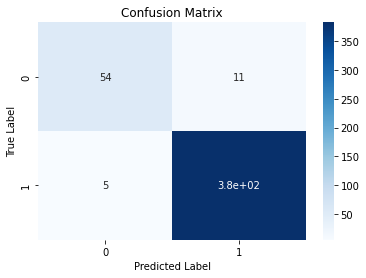

In [88]:
# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(Slow12, FENICS12.Board.StatusSlow, test_size=0.2, random_state=42)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# define the neural network architecture
class BurninTestNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BurninTestNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# set hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 10
output_dim = 1
lr = 0.001
n_epochs = 5000

# initialize the neural network
net = BurninTestNN(input_dim, hidden_dim, output_dim)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

# train the neural network
for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = net(torch.FloatTensor(X_train))
    loss = criterion(outputs.squeeze(), torch.FloatTensor(y_train.values))
    loss.backward()
    optimizer.step()

    # print the loss for every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# evaluate the neural network on the test set
with torch.no_grad():
    net.eval()
    test_outputs = net(torch.FloatTensor(X_test))
    test_loss = criterion(test_outputs.squeeze(), torch.FloatTensor(y_test.values))
    test_accuracy = ((test_outputs > 0).float() == torch.FloatTensor(y_test.values.reshape(-1, 1))).float().mean()
    test_predictions = (test_outputs > 0).int()

    print(f'Test Loss: {test_loss.item()}')
    print(f'Test Accuracy: {test_accuracy.item()}')
    
    # Plot a confusion matrix
    cm = confusion_matrix(y_test, test_predictions)
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# # print the weights of the neural network
# print(f'FC1 Weights: {net.fc1.weight}')
# print(f'FC2 Weights: {net.fc2.weight}')

Test Loss: 0.4548366367816925
Test Accuracy: 0.8896247148513794


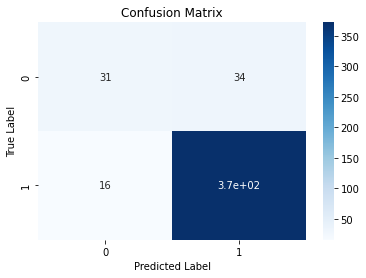

In [59]:
# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(Fast12, FENICS12.Board.StatusSlow, test_size=0.2, random_state=42)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# define the neural network architecture
class BurninTestNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BurninTestNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# set hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 10
output_dim = 1
lr = 0.001
n_epochs = 5000

# initialize the neural network
net = BurninTestNN(input_dim, hidden_dim, output_dim)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

# train the neural network
for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = net(torch.FloatTensor(X_train))
    loss = criterion(outputs.squeeze(), torch.FloatTensor(y_train.values))
    loss.backward()
    optimizer.step()

    # # print the loss for every 10 epochs
    # if epoch % 10 == 0:
    #     print(f'Epoch {epoch}, Loss: {loss.item()}')

# evaluate the neural network on the test set
with torch.no_grad():
    net.eval()
    test_outputs = net(torch.FloatTensor(X_test))
    test_loss = criterion(test_outputs.squeeze(), torch.FloatTensor(y_test.values))
    test_accuracy = ((test_outputs > 0).float() == torch.FloatTensor(y_test.values.reshape(-1, 1))).float().mean()
    test_predictions = (test_outputs > 0).int()

    print(f'Test Loss: {test_loss.item()}')
    print(f'Test Accuracy: {test_accuracy.item()}')
    
    # Plot a confusion matrix
    cm = confusion_matrix(y_test, test_predictions)
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# # print the weights of the neural network
# print(f'FC1 Weights: {net.fc1.weight}')
# print(f'FC2 Weights: {net.fc2.weight}')

Test Loss: 0.26997628808021545
Test Accuracy: 0.9668874144554138


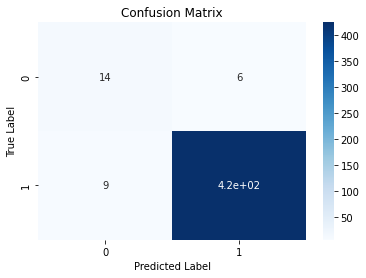

In [60]:
# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(Slow12, FENICS12.Board.StatusFast, test_size=0.2, random_state=42)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# define the neural network architecture
class BurninTestNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BurninTestNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# set hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 10
output_dim = 1
lr = 0.001
n_epochs = 5000

# initialize the neural network
net = BurninTestNN(input_dim, hidden_dim, output_dim)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

# train the neural network
for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = net(torch.FloatTensor(X_train))
    loss = criterion(outputs.squeeze(), torch.FloatTensor(y_train.values))
    loss.backward()
    optimizer.step()

    # # print the loss for every 10 epochs
    # if epoch % 10 == 0:
    #     print(f'Epoch {epoch}, Loss: {loss.item()}')

# evaluate the neural network on the test set
with torch.no_grad():
    net.eval()
    test_outputs = net(torch.FloatTensor(X_test))
    test_loss = criterion(test_outputs.squeeze(), torch.FloatTensor(y_test.values))
    test_accuracy = ((test_outputs > 0).float() == torch.FloatTensor(y_test.values.reshape(-1, 1))).float().mean()
    test_predictions = (test_outputs > 0).int()

    print(f'Test Loss: {test_loss.item()}')
    print(f'Test Accuracy: {test_accuracy.item()}')
    
    # Plot a confusion matrix
    cm = confusion_matrix(y_test, test_predictions)
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# # print the weights of the neural network
# print(f'FC1 Weights: {net.fc1.weight}')
# print(f'FC2 Weights: {net.fc2.weight}')

Test Loss: 0.3878394663333893
Test Accuracy: 0.9448123574256897


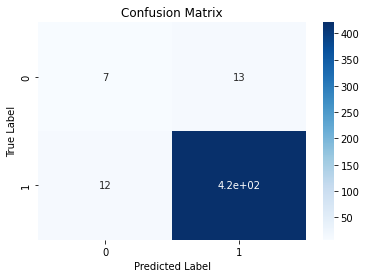

In [61]:
# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(Fast12, FENICS12.Board.StatusFast, test_size=0.2, random_state=42)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# define the neural network architecture
class BurninTestNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BurninTestNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# set hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 10
output_dim = 1
lr = 0.001
n_epochs = 5000

# initialize the neural network
net = BurninTestNN(input_dim, hidden_dim, output_dim)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

# train the neural network
for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = net(torch.FloatTensor(X_train))
    loss = criterion(outputs.squeeze(), torch.FloatTensor(y_train.values))
    loss.backward()
    optimizer.step()

    # # print the loss for every 10 epochs
    # if epoch % 10 == 0:
    #     print(f'Epoch {epoch}, Loss: {loss.item()}')

# evaluate the neural network on the test set
with torch.no_grad():
    net.eval()
    test_outputs = net(torch.FloatTensor(X_test))
    test_loss = criterion(test_outputs.squeeze(), torch.FloatTensor(y_test.values))
    test_accuracy = ((test_outputs > 0).float() == torch.FloatTensor(y_test.values.reshape(-1, 1))).float().mean()
    test_predictions = (test_outputs > 0).int()

    print(f'Test Loss: {test_loss.item()}')
    print(f'Test Accuracy: {test_accuracy.item()}')
    
    # Plot a confusion matrix
    cm = confusion_matrix(y_test, test_predictions)
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# # print the weights of the neural network
# print(f'FC1 Weights: {net.fc1.weight}')
# print(f'FC2 Weights: {net.fc2.weight}')

Test Loss: 0.6287602782249451
Test Accuracy: 0.9580574035644531


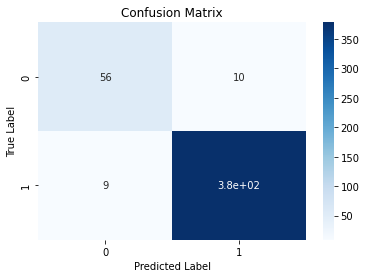

In [74]:
# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(FastSlow12, FENICS12_LTT.Board.StatusSlow, test_size=0.2, random_state=42)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# define the neural network architecture
class BurninTestNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BurninTestNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# set hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 10
output_dim = 1
lr = 0.001
n_epochs = 5000

# initialize the neural network
net = BurninTestNN(input_dim, hidden_dim, output_dim)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

# train the neural network
for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = net(torch.FloatTensor(X_train))
    loss = criterion(outputs.squeeze(), torch.FloatTensor(y_train.values))
    loss.backward()
    optimizer.step()

    # # print the loss for every 10 epochs
    # if epoch % 10 == 0:
    #     print(f'Epoch {epoch}, Loss: {loss.item()}')

# evaluate the neural network on the test set
with torch.no_grad():
    net.eval()
    test_outputs = net(torch.FloatTensor(X_test))
    test_loss = criterion(test_outputs.squeeze(), torch.FloatTensor(y_test.values))
    test_accuracy = ((test_outputs > 0).float() == torch.FloatTensor(y_test.values.reshape(-1, 1))).float().mean()
    test_predictions = (test_outputs > 0).int()

    print(f'Test Loss: {test_loss.item()}')
    print(f'Test Accuracy: {test_accuracy.item()}')
    
    # Plot a confusion matrix
    cm = confusion_matrix(y_test, test_predictions)
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# # print the weights of the neural network
# print(f'FC1 Weights: {net.fc1.weight}')
# print(f'FC2 Weights: {net.fc2.weight}')

In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Load data and preprocess
data = Slow12
labels = FENICS12.Board.StatusSlow
burn_time = FENICS12.Board.burnTime
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)
scaler = MinMaxScaler(feature_range=(0, 1))
burn_time = scaler.fit_transform(burn_time.values.reshape(-1, 1))
data = np.hstack((burn_time, labels.reshape(-1, 1)))

# Split data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2)

# Define generator model
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(16, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(2, activation='sigmoid'))
    return model

# Define discriminator model
def build_discriminator():
    model = Sequential()
    model.add(Dense(32, input_dim=2))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(16))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Compile models
latent_dim = 10
generator = build_generator(latent_dim)
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
discriminator.trainable = False
gan = Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

# Train GAN
epochs = 10000
batch_size = 16
half_batch = int(batch_size / 2)
for epoch in range(epochs):
    # Train discriminator
    real_data = train_data[np.random.randint(0, train_data.shape[0], half_batch)]
    noise = np.random.normal(0, 1, (half_batch, latent_dim))
    fake_data = generator.predict(noise)
    real_labels = np.ones((half_batch, 1))
    fake_labels = np.zeros((half_batch, 1))
    d_loss_real = discriminator.train_on_batch(real_data, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    # Train generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
    # Print progress
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | D loss: {d_loss[0]:.4f} | D accuracy: {d_loss[1]:.4f} | G loss: {g_loss:.4f}')

# Generate fake test cards
num_fake_cards = 100
noise = np.random.normal(0, 1, (num_fake_cards, latent_dim))
fake_labels = np.ones((num_fake_cards, 1))  # Change to zeros for

Epoch: 0 | D loss: 0.6982 | D accuracy: 0.4375 | G loss: 0.6905
Epoch: 100 | D loss: 0.6733 | D accuracy: 0.8125 | G loss: 0.7043
Epoch: 200 | D loss: 0.6769 | D accuracy: 0.5625 | G loss: 0.6547
Epoch: 300 | D loss: 0.6780 | D accuracy: 0.5000 | G loss: 0.6511
Epoch: 400 | D loss: 0.6920 | D accuracy: 0.5000 | G loss: 0.6587
Epoch: 500 | D loss: 0.6909 | D accuracy: 0.5000 | G loss: 0.6657
Epoch: 600 | D loss: 0.6904 | D accuracy: 0.7500 | G loss: 0.6833
Epoch: 700 | D loss: 0.6932 | D accuracy: 0.5625 | G loss: 0.7207
Epoch: 800 | D loss: 0.6848 | D accuracy: 0.6250 | G loss: 0.7288
Epoch: 900 | D loss: 0.7061 | D accuracy: 0.3750 | G loss: 0.7122
Epoch: 1000 | D loss: 0.6847 | D accuracy: 0.6250 | G loss: 0.7069
Epoch: 1100 | D loss: 0.6893 | D accuracy: 0.5625 | G loss: 0.7002
Epoch: 1200 | D loss: 0.6942 | D accuracy: 0.4375 | G loss: 0.7021
Epoch: 1300 | D loss: 0.6970 | D accuracy: 0.4375 | G loss: 0.6983
Epoch: 1400 | D loss: 0.6965 | D accuracy: 0.6250 | G loss: 0.6743
Epoch: 